# eBay 

The dataset, `ebay_ho2.parquet`, contains rows, each corresponding to a sold item on eBay under the *Best Offer* platform. 

The data comes from https://www.nber.org/research/data/best-offer-sequential-bargaining, from the paper “Sequential Bargaining in the Field: Evidence from Millions of Online Interactions” by Backus, Blake, Larsen & Tadelis (2020) in the Quarterly Journal of Economics. 

In [4]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression


In [5]:
dat = pd.read_parquet('ebay_ho2.parquet')

In [6]:
dat.shape

(7903479, 22)

Variable labels in human readable form

In [7]:
var_labels = {'anon_item_id': 'Anonymized listing ID',
              'anon_leaf_categ_id': 'Anonymized leaf category ID, a finer categorization than meta categor',
              'fdbk_pstv_start':'sellers percent feedback score at the time of the listin',
              'start_price_usd': 'Buy-It-Now price', 'photo_count': 'Number of photos in listing', 
              'to_lst_cnt': 'Number of listings created by the seller dating back to 2008',
              'bo_lst_cnt': 'Number of BO-listings created by the seller dating back to 2008',
              'item_cndtn_id': 'Indicator for the new/used status of the item',
              'view_item_count': 'Number of times the item page was viewed',
              'wtchr_count': 'Number of users who selected the "add to watch list" option for this listing',              
              'anon_product_id': 'Anonymized product ID, only available for items that can be linked to specific cataloged products', 
              'count1': 'Number of listings used in creating ref_price1 for this observation',
              'ref_price1': 'Average price for sold fixed price listings with the same listing title as this item, sold during the time frame of the data',   
              'item_price': 'Final price (Buy-It-Now price if the item sold through Buy-It-Now option, or the final negotiated price if the item sold through Best Offer. ',
              'bo_ck_yn': 'Indicator for whether item sold through best offer.',
              'decline_price': 'Price chosen by seller, if the seller chooses to report one, below which any offer will be automatically rejected', 
              'accept_price': 'Price chosen by seller, if the seller chooses to report one, above which any offer will be automatically accepted', 
              'bin_rev': 'Indicator for whether the Buy-It-Now price was ever modified by the seller during the time the item was listed', 
              'lstg_gen_type_id': 'Indicator for whether the item is a re-listing (i.e. an item that failed to sell before and was then re-listed by the seller)', 
              'store': 'Indicator for whether the listing is part of an eBay store',
              'slr_us': 'Indicator for whether seller is located in US or not', 
              'buyer_us': 'Indicator for whether buyer is located in US or not', 
              'metacat': 'Product category (broad)', 
              'item_condition': 'Indicator for the new/used status of the item (categorical).', 
              'price2ref': 'Price relative to avg. among identical products (ref_price1)', 
              'price2start': 'Price relative to starting price (start_price_usd)'
             }

In [8]:
for v in dat.columns: 
    print(f'{v:<20}: {var_labels[v]}')

anon_product_id     : Anonymized product ID, only available for items that can be linked to specific cataloged products
anon_leaf_categ_id  : Anonymized leaf category ID, a finer categorization than meta categor
fdbk_pstv_start     : sellers percent feedback score at the time of the listin
start_price_usd     : Buy-It-Now price
photo_count         : Number of photos in listing
to_lst_cnt          : Number of listings created by the seller dating back to 2008
bo_lst_cnt          : Number of BO-listings created by the seller dating back to 2008
count1              : Number of listings used in creating ref_price1 for this observation
ref_price1          : Average price for sold fixed price listings with the same listing title as this item, sold during the time frame of the data
view_item_count     : Number of times the item page was viewed
wtchr_count         : Number of users who selected the "add to watch list" option for this listing
item_price          : Final price (Buy-It-Now price 

# Create variables

In [9]:
dat['price2ref']   = dat['item_price'] / dat['ref_price1']
dat['price2start'] = dat['item_price'] / dat['start_price_usd']

In [10]:
price_vars = ['item_price', 'price2ref', 'price2start']

In [11]:
price_labs = {'price2ref':'Price rel. to avg. for product', 'price2start':'Price rel. to starting price', 
              'item_price':'Price (USD)'}

# A few descriptives, just for curiosity

## Number of sales per category

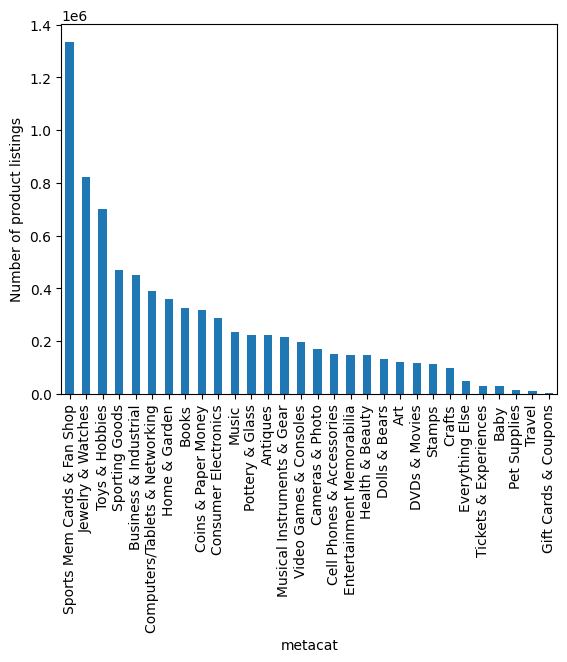

In [12]:
ax=dat.metacat.value_counts().plot(kind='bar'); 
ax.set_ylabel('Number of product listings'); 

## Price distributions

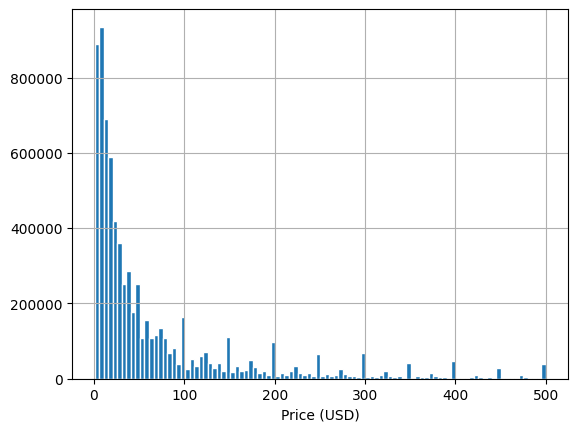

In [13]:
I = dat.item_price <= 500 # just to remove a few outliers 
ax = dat.loc[I].item_price.hist(bins=100,edgecolor='white'); 
ax.set_xlabel(price_labs['item_price']); 

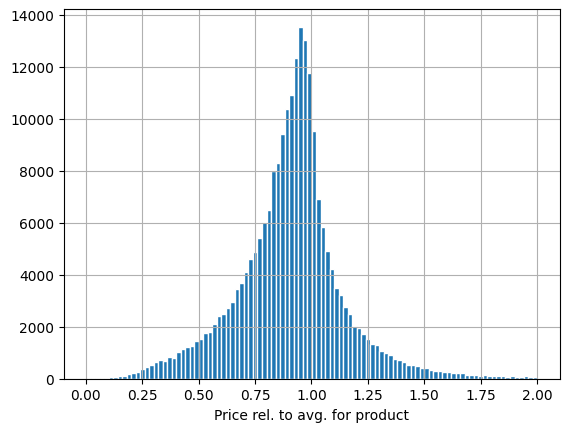

In [14]:
I = (dat.price2ref <= 2.0) & (dat.count1 >= 10) # if count1<10, then the reference price gets very noisy
ax = dat.loc[I].price2ref.hist(bins=100,edgecolor='white'); 
ax.set_xlabel(price_labs['price2ref']); 

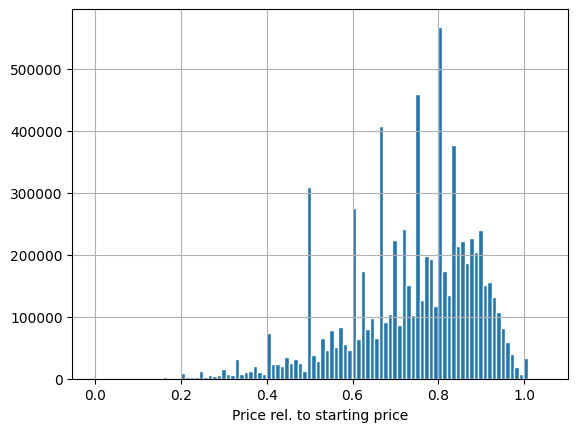

In [15]:
I = (dat.price2start <= 1.05) 
ax = dat.loc[I].price2start.hist(bins=100,edgecolor='white'); 
ax.set_xlabel(price_labs['price2start']); 

# Compare prices for two specific categories

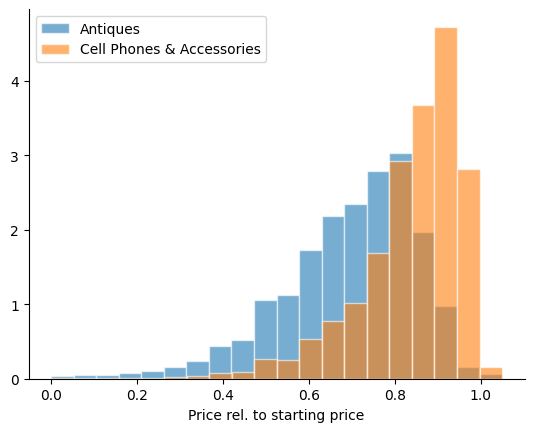

In [16]:
cats = ['Antiques',  'Cell Phones & Accessories']

fig,ax = plt.subplots(); 
for cat in cats: 
    I = (dat['price2start'] < 1.05) & (dat.metacat == cat)
    ax.hist(dat.loc[I, 'price2start'], bins=20, label=cat, alpha=0.6, density=True, edgecolor='white')

ax.legend(loc='best'); ax.set_xlabel(price_labs['price2start']); sns.despine();     

# Part A: Uniform valuations

This section focuses on the variable `price2start`, which is neatly distributed between 0 and 1, motivating us to focus on the uniform distribution. 

In [17]:
d = dat.groupby('metacat')[['price2start', 'view_item_count']].mean()
d

/tmp/ipykernel_6714/3995507957.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = dat.groupby('metacat')[['price2start', 'view_item_count']].mean()


,price2start,view_item_count
metacat,,
Antiques,0.697898,45.201430
Art,0.678380,33.178491
Baby,0.759839,38.750195
Books,0.697726,19.118065
Business & Industrial,0.720395,36.085501
Cameras & Photo,0.795037,52.978987
Cell Phones & Accessories,0.842814,64.304693
Coins & Paper Money,0.794811,31.213884
Computers/Tablets & Networking,0.796257,45.466562


... continue on your own from here... write a function that takes `d.view_item_count` as an input and returns a predicted price. The data price that this should be compared to is `d.price2start`. 

## 3.2

In [18]:
fraction_active = 0.2
d['predicted_price'] = (d.view_item_count*fraction_active-1)/(d.view_item_count*fraction_active+1)
d[['price2start','predicted_price']].to_latex


<bound method NDFrame.to_latex of                                 price2start  predicted_price
metacat                                                     
Antiques                           0.697898         0.800802
Art                                0.678380         0.738072
Baby                               0.759839         0.771430
Books                              0.697726         0.585373
Business & Industrial              0.720395         0.756605
Cameras & Photo                    0.795037         0.827524
Cell Phones & Accessories          0.842814         0.855710
Coins & Paper Money                0.794811         0.723863
Computers/Tablets & Networking     0.796257         0.801849
Consumer Electronics               0.778015         0.830240
Crafts                             0.723743         0.684176
DVDs & Movies                      0.743048         0.562066
Dolls & Bears                      0.729141         0.758313
Entertainment Memorabilia          0.686469        

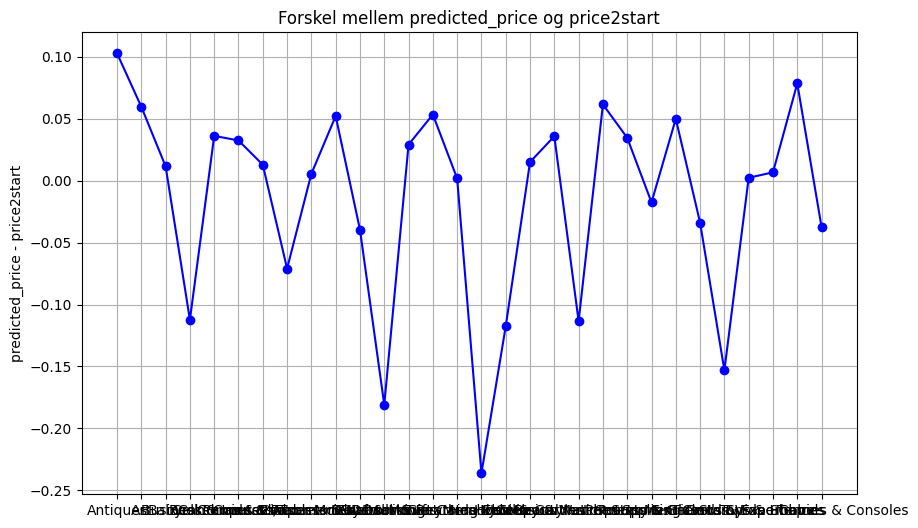

In [19]:
d['difference'] = d['predicted_price'] - d['price2start']

plt.figure(figsize=(10, 6))
plt.plot(d.index, d['difference'], marker='o', linestyle='-', color='b')
plt.ylabel('predicted_price - price2start')
plt.title('Forskel mellem predicted_price og price2start')
plt.grid(True)
plt.show()

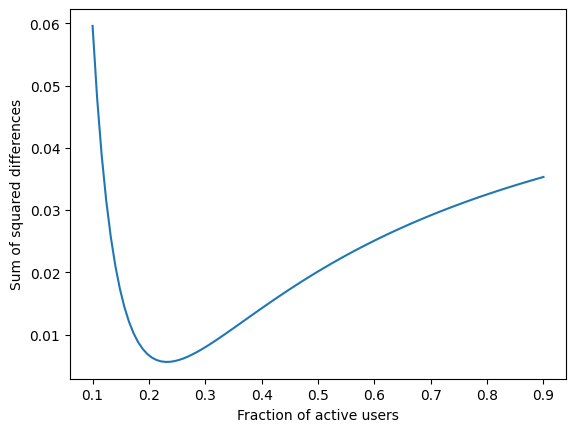

In [20]:
def q(fraction_active):
    d['expected_bid'] = (d.view_item_count*fraction_active-1)/(d.view_item_count*fraction_active+1)
    d['difference'] = d.price2start - d.expected_bid
    return np.sum(d.difference**2)/30

x = np.linspace(0.1, 0.9, 100)
y = [q(f) for f in x]
plt.plot(x,y); plt.xlabel('Fraction of active users'); plt.ylabel('Sum of squared differences');


In [21]:
res = minimize(q, 0.2, bounds=[(0, 1)])
res.x[0]


np.float64(0.23186192956806576)

## 3.4

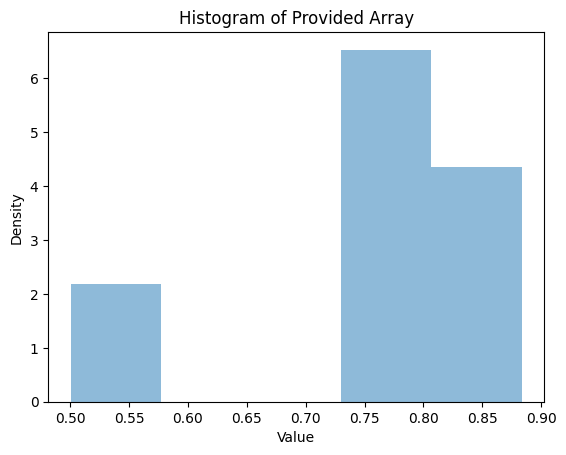

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Provided array
p = np.array([0.88333333, 0.8004002, 0.86550113, 0.76982294, 0.5005005, 0.75018755])

# Create the histogram
plt.hist(p, density=True, alpha=0.5, bins=5)  # using bins=5 to show the distribution more clearly

# Setting the x-axis and y-axis labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Provided Array')

# Show the plot
plt.show()


Minimum: 0.0014285918370262431, Maximum: 103.33333333333333


(array([4.82547477e-03, 7.11122598e-03, 1.31430694e-02, 5.13024160e-02,
        1.76383802e-01, 3.25402082e-01, 8.64458408e-01, 1.97317473e+00,
        4.12076498e+00, 2.10422447e+00, 1.77780649e-02, 6.53978818e-03,
        2.53972356e-03, 1.58732723e-03, 1.52383414e-03, 5.07944713e-04,
        1.07938251e-03, 5.07944713e-04, 2.53972356e-04, 5.07944713e-04,
        2.53972356e-04, 0.00000000e+00, 1.26986178e-04, 6.34930891e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.34930891e-05,
        6.34930891e-05, 6.34930891e-05, 6.34930891e-05, 0.00000000e+00,
        6.34930891e-05, 0.00000000e+00, 1.90479267e-04, 6.34930891e-05,
        6.34930891e-05, 0.00000000e+00, 1.26986178e-04, 6.34930891e-05,
        0.00000000e+00, 1.26986178e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.34930891e-05, 6.34930891e-05, 6.34930891e-05,
        1.26986178e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.34930891e-05, 0.00000000e+00, 6.34930891e-05, 6.349308

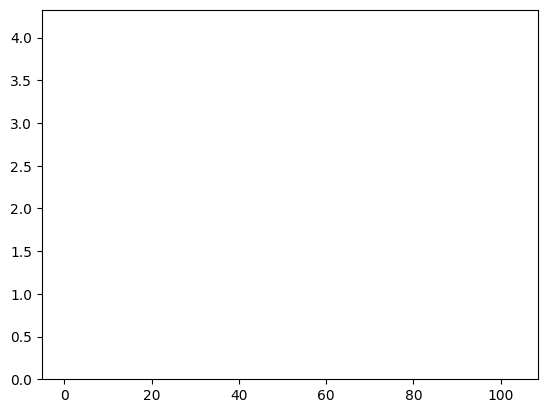

In [23]:
# Price2start from all listings with category Cell Phones & Accessories
I = (dat.metacat == 'Cell Phones & Accessories')
price2start_series = dat.loc[I, 'price2start']
price2start_series_v = price2start_series.values

price2start_series_v

minimum = np.min(price2start_series_v)
maximum = np.max(price2start_series_v)
print(f'Minimum: {minimum}, Maximum: {maximum}')

#Find the max listing in the original data
max_listing = dat.loc[dat['price2start'] == maximum]

max_listing

# Plot the distribution of price2start for the category Cell Phones & Accessories The x axis should be from 0-1 and only have 
plt.hist(price2start_series_v, bins=1000,density=True, edgecolor='white')



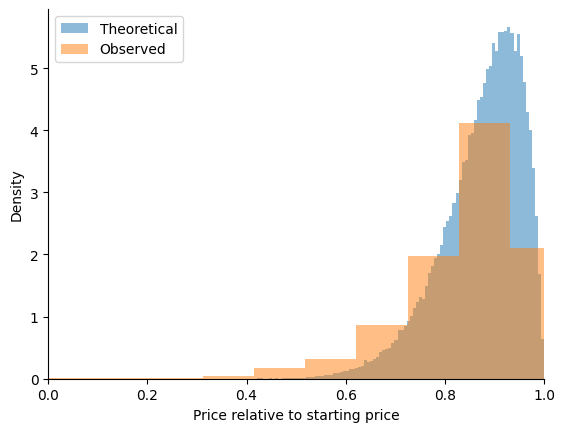

In [24]:
np.random.seed(1776)
samples = np.random.beta(64*0.23-1, 2, 100000)
theoretical_mean = np.mean(samples)


plt.hist(samples, density=True, alpha=0.5, bins=100, label='Theoretical')
plt.hist(price2start_series_v, density=True, alpha=0.5, bins=1000, label='Observed')

plt.xlim(0, 1)

plt.legend(loc='best')
plt.xlabel('Price relative to starting price')
plt.ylabel('Density')
sns.despine()
plt.show()

In [25]:
## 3.5 

In [26]:
d = dat.groupby('metacat')['view_item_count'].mean()
d.idxmax()




/tmp/ipykernel_6714/2188749099.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = dat.groupby('metacat')['view_item_count'].mean()


'Musical Instruments & Gear'

In [27]:
view_counts = dat.loc[dat.metacat == 'Musical Instruments & Gear', 'view_item_count'].mean()
view_counts


np.float64(71.0230839067058)

Theoretical mean: 0.890, observed mean: 0.807


(0.0, 1.0)

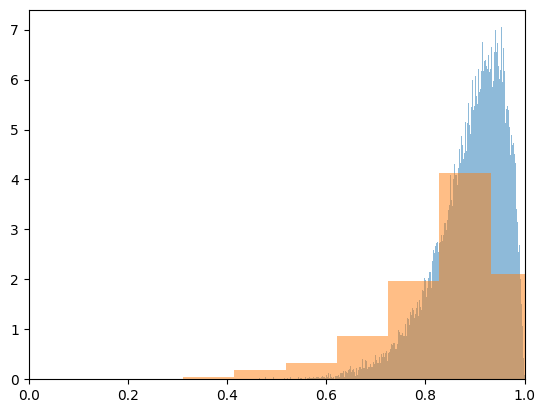

In [28]:
np.random.seed(1776)
samples = np.random.beta((71-1)*0.23, 2, 100000)
theoretical_mean = np.mean(samples)

mean_price2start = dat.loc[dat.metacat == 'Musical Instruments & Gear', 'price2start'].mean()


print(f'Theoretical mean: {theoretical_mean:.3f}, observed mean: {mean_price2start:.3f}')

plt.hist(samples, density=True, alpha=0.5, bins=1000, label='Theoretical')
plt.hist(price2start_series_v, density=True, alpha=0.5, bins=1000, label='Observed')

plt.xlim(0, 1)
	

# Part B: Non-uniformly Distributed Valuations

Now, we instead focus on the price variable, `price2ref`. 

In [29]:
price_var = 'price2ref'

## Subset the dataset

In [30]:
I = (dat.metacat == 'Cell Phones & Accessories') & (dat.price2ref < 2.0) & (dat.count1 >= 10)
d = dat[I].copy() # to avoid having a pointer 

Showing the overall distribution of that price

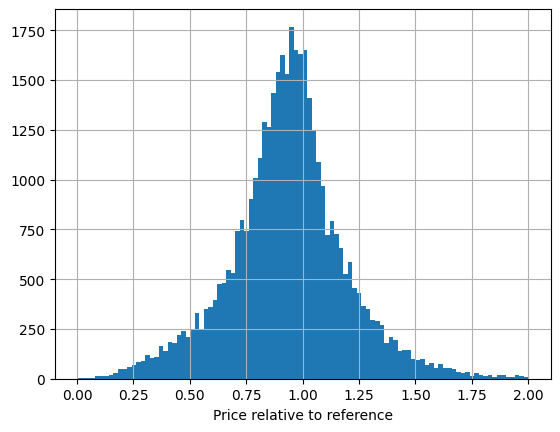

In [31]:
d[price_var].hist(bins=100); 
plt.xlabel('Price relative to reference'); 

## Question B.1

In [32]:
n = 10
R = 100000

v = np.random.chisquare(1, size=(n, R))


v_sorted = np.sort(v, axis=0)
win_chi2 = v_sorted[-2, :]

w = np.exp(np.random.normal(-0.5, 0.5, size=(n, R)))

w_sorted = np.sort(w, axis=0)
win_lognorm = w_sorted[-2, :]

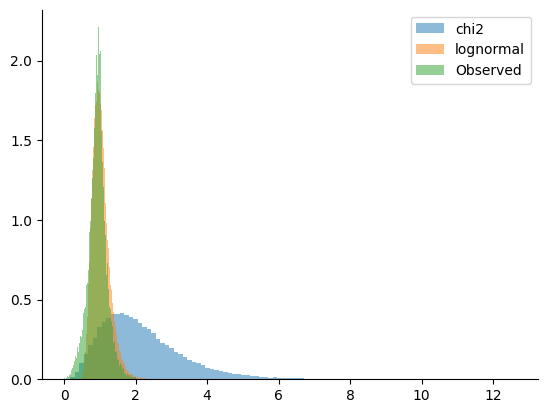

In [33]:
# if you called the variables "win_chi2" and "win_lognorm", 
# then this code creates a graph with the histograms together 
fig,ax = plt.subplots(); 
ax.hist(win_chi2,       alpha=0.5, density=True, bins=100, label='chi2');      # winning bids with chi squared distributed valuations
ax.hist(win_lognorm,    alpha=0.5, density=True, bins=100, label='lognormal'); # ... with log normals 
ax.hist(d['price2ref'], alpha=0.5, density=True, bins=100, label='Observed');  # the data we want to compare to 
ax.legend(loc='best'); sns.despine(); 

## Question B.2

Find the $\mu$ that best fits the data. Two approaches: 
1. Just evaluate histograms for different values of $\mu$ and search "with your eye" *(minimum acceptable solution)* 
2. Minimize the "distance" between the simulated and real data. See the attached notebook, `ecdf.ipynb` for help. 

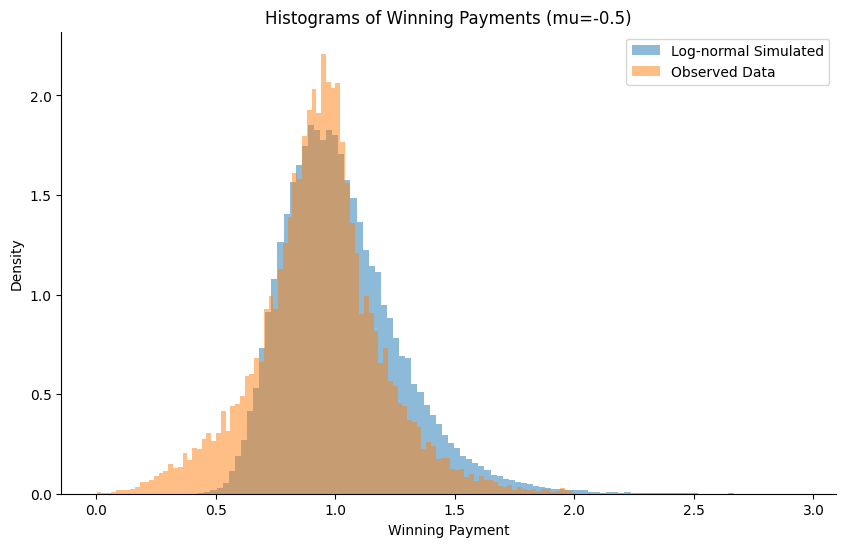

In [34]:
observed_data = d['price2ref']

def simulate_auctions(mu, sigma=0.5, n=10, R=100000):
    w = np.exp(np.random.normal(mu, sigma, size=(n, R)))

    w_sorted = np.sort(w, axis=0)
    win_lognorm = w_sorted[-2, :]  

    return win_lognorm

def plot_histograms(mu, observed_data):
    win_lognorm = simulate_auctions(mu)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(win_lognorm, alpha=0.5, density=True, bins=100, label='Log-normal Simulated')
    ax.hist(observed_data, alpha=0.5, density=True, bins=100, label='Observed Data')
    ax.legend(loc='best')
    sns.despine()
    plt.xlabel('Winning Payment')
    plt.ylabel('Density')
    plt.title(f'Histograms of Winning Payments (mu={mu})')
    plt.show()

mu = -0.5
plot_histograms(mu, observed_data)


L2 criterion for these values =  0.004
{'mu': np.float64(-0.5718750000000001), 'L2': np.float64(0.0006174197841456523)}


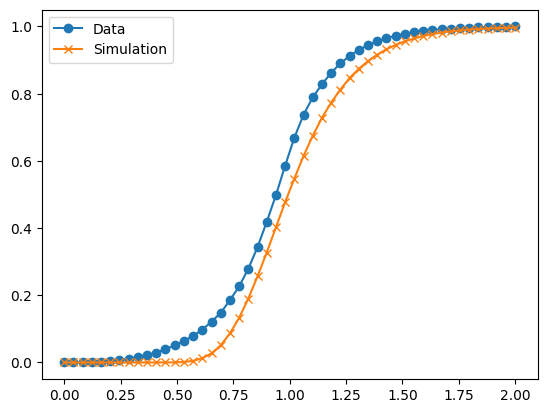

In [35]:
# 1. set up the grid on which we will be evaluating the ECDF functions
plow = 0.0
phigh = 2.0
xx = np.linspace(plow, phigh, 50)

# 2. construct the empirical CDF function handles
# ECDF returns a *function* which you can then evaluate at a vector of points 
ecdf_dat = ECDF(d['price2ref']) # the CDF function for the data 
ecdf_sim = ECDF(win_lognorm) # the variable from question B.1

# 3. show a plot together 
# we evaluate the two cdf functions on the same grid
plt.plot(xx, ecdf_dat(xx), '-o', xx, ecdf_sim(xx), '-x'); 
plt.legend(['Data', 'Simulation']); 

# 4. compute the L2 distance between the two CDF functions
# (see ecdf.ipynb for help with this)
L2 = np.mean((ecdf_dat(xx) - ecdf_sim(xx))**2)
print(f'L2 criterion for these values = {L2:6.3f}')

# Make a function that takes the mu parameter and returns the distance
def L2_distance(mu, observed_data):
    win_lognorm = simulate_auctions(mu)
    ecdf_sim = ECDF(win_lognorm)
    ecdf_dat = ECDF(observed_data)
    xx = np.linspace(0, 2, 1000)
    L2 = np.mean((ecdf_dat(xx) - ecdf_sim(xx))**2)
    return L2

# Minimize the L2 distance as a function of mu
res = minimize(L2_distance, -0.5, args=(observed_data,),method='Nelder-Mead')
print({'mu': res.x[0], 'L2': res.fun})

mu_opt = res.x[0]
sigma_opt = 0.5

# 3B.3

In [49]:
from scipy import stats

F_draw = lambda size : np.random.lognormal(mean=mu_opt, sigma=sigma_opt, size=size)
F_cdf  = lambda x : stats.lognorm.cdf(x, s=1, scale=np.exp(0))
F_pdf  = lambda x : stats.lognorm.pdf(x, s=1, scale=np.exp(0))

In [45]:
def draw_from_truncated(F_draw, vbar, n, R): 
    assert vbar > 0.0, f'Cannot draw from a truncated distribution with vbar={vbar}: no observations'
    desired_size = n*R

    # how many extra draws are required? 
    extra_draws = 1.0 / F_cdf(vbar) * 1.1 # 10% more just to be sure 
    largenum = np.round(desired_size*extra_draws).astype(int)

    # draw 
    v_untrunc = F_draw(size=(largenum,))

    # perform truncation
    v_trunc = v_untrunc[(v_untrunc <= vbar)].copy()

    # drop excess rows so we have a regular array
    drop_this_many = np.mod(v_trunc.size, n)
    if drop_this_many != 0: 
        v_trunc = v_trunc[:-drop_this_many]

    # regularize array
    v_sim = v_trunc.reshape(n, -1)

    return v_sim 

In [51]:
def b_star(v): 
    if v == 0.0: 
        return 0.0
    v_losers = draw_from_truncated(F_draw, vbar=v, n=n-1, R=R)
    vmax = v_losers.max(axis=0)
    Ev_2nd = np.mean(vmax)
    return Ev_2nd

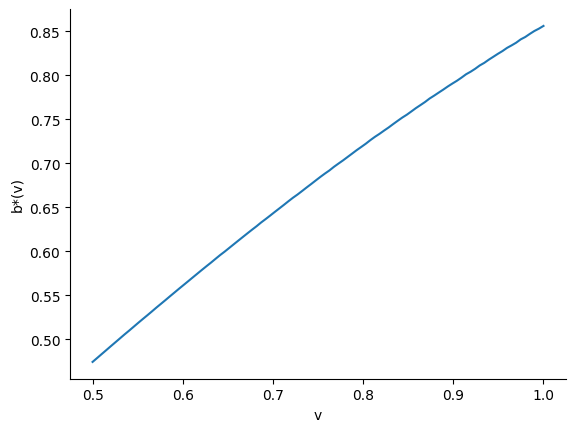

In [52]:
# Evaluate bstar in {0.5,1.0} and show it graphically
v = np.linspace(0.5, 1.0, 100)
bstar = np.array([b_star(vi) for vi in v])

plt.plot(v, bstar); plt.xlabel('v'); plt.ylabel('b*(v)'); sns.despine();


